<a href="https://colab.research.google.com/github/ShrungaM/Online-Retail-Customer-Segmentation/blob/main/Online_Retail_Customer_Segmentation_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Online Retail Customer Segmentation </u></b>

## <b> Problem Description </b>

### In this project, your task is to identify major customer segments on a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## <b> Data Description </b>

### <b>Attribute Information: </b>

* ### InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* ### StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* ### Description: Product (item) name. Nominal.
* ### Quantity: The quantities of each product (item) per transaction. Numeric.
* ### InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* ### UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* ### CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* ### Country: Country name. Nominal, the name of the country where each customer resides.

#**Importing the necessary libraries and reading the file**

In [1]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
from numpy import math
import scipy.stats as stat
from datetime import datetime
import datetime as dt 

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# #Importing Dataset
# dataset = pd.read_excel("/content/drive/MyDrive/Data/Online Retail.xlsx")
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML/datasets/Online_Retail.xlsx - Online Retail.csv")

creating a copy of dataset

In [4]:
df = dataset.copy()

#**Defining necessary functions**

In [5]:
def check_duplicates(dataset):
  '''This function will print if there are duplicates in the dataset'''
  
  if(len(dataset[dataset.duplicated()])>0):
    print("There are duplicates in the data. The number of Duplicates are ",len(dataset[dataset.duplicated()]))
  else:
    print("There are no duplicates")

In [6]:
def visualize_missing_percent(dataset):
  '''This function takes the dataframe as input as the input and gives the count of missing values,
  missing values in percentage per column and plots the same in a bargraph'''
  
  #total percentage of missing data
  if dataset.isnull().sum().sum()>0:
    print("Missing values found..Calculating the total...")
    missing_data = dataset.isnull().sum()
    total_percentage = (missing_data.sum()/dataset.shape[0]) * 100
    print(f'The total number of missing entries found is {dataset.isnull().sum().sum()}, that is {round(total_percentage,2)}%')
    print('')

    # percentage of missing data per category
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent_total = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)*100
    missing = pd.concat([total, percent_total], axis=1, keys=["Total", "Percentage"])
    missing_data = missing[missing['Total']>0]
    print(missing_data)
    print('')

    #Visualize the missing value percentage
    plt.figure(figsize=(9,6))
    sns.set(style="whitegrid")
    sns.barplot(x=missing_data.index, y=missing_data['Percentage'], data = missing_data)
    plt.title('Percentage of missing data by feature', fontsize=16)
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.show()
  else:
    print('Hurray! There are no missing values in the data.')


In [7]:
def bargraph(df,X,Y,title):
  '''This function takes the columns of the dataframe as input 
  and gives barplot as output'''

  # Figure Size
  sns.set(rc={'figure.figsize':(19,7)})

  # creating the bar plot
  sns.barplot(x=X, y=Y, data=df,order=df[X],palette='flare_r')

  # set title
  plt.title(title, size=20)

  ## Showing the plot
  plt.show()


In [8]:
def time_type(time):
  '''This function takes the time as input and 
  gives time_type like morning,afternoon or evening has output'''
  if(time==6 or time==7 or time==8 or time==9 or time==10 or time==11):
    return 'Morning'
  elif(time==12 or time==13 or time==14 or time==15 or time==16):
    return 'Afternoon'
  else:
    return 'Evening'

In [9]:
def check_skew(df, column):
    '''This function is used to check and plot the skewness'''
    skew = stat.skew(df[column])
    skewtest = stat.skewtest(df[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return 

In [10]:
def handle_neg_n_zero(num):
    '''This function is used to handle negative and zero values 
    so as to handle infinite numbers during log transformation'''
    if num <= 0:
        return 1
    else:
        return num

In [11]:
#Functions used in RFM model
def RScoring(x,p,d):
    '''Function to create Recency segment'''
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FnMScoring(x,p,d):
    '''Function to create Frequency and Monetary segment'''
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

#**Data Exploration**

In [12]:
print("The shape of the dataset is ",df.shape)

The shape of the dataset is  (541909, 8)


In [13]:
original_rows = df.shape[0]
original_rows

541909

In [14]:
#Familiarize with the dataset columns
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [15]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/11 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/11 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/11 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/11 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/11 12:50,4.95,12680.0,France


In [16]:
#Checking the datatype of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [17]:
print("Lets take a look at the statistics of the columns")
df.describe(include='all')

Lets take a look at the statistics of the columns


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900,4070,4223,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,10/31/11 14:41,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16791.000000,NaN


**Potential data reversal.**

*  The max and min value of Quantity are both 80995; it could represent a 
reversal of data entry. However, the issue is that both the initial and reversal entry are retained in the dataset. Further investigation is needed to understand the nature and determine the best way to manage such data reversal.

**Potential indication of cancellation orders from negative UnitPrice.**

*  It is uncommon to have negative UnitPrice, as this would mean a cash outflow to a company. These transactions could represent cancelled orders by customers or bad-debt incurred by the business.

###**Checking for Duplicate**

In [18]:
#Checking for duplicates
check_duplicates(df)

There are duplicates in the data. The number of Duplicates are  5268


Lets drop duplicates in the data.

In [19]:
df.drop_duplicates(keep = False, inplace = True)

In [20]:
df.shape

(531762, 8)

In [21]:
#Checking for duplicates
check_duplicates(df)

There are no duplicates


###**Checking for Null/Missing Values**

In [22]:
#Familiarise with the columns in the dataset and their data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531762 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    531762 non-null  object 
 1   StockCode    531762 non-null  object 
 2   Description  530308 non-null  object 
 3   Quantity     531762 non-null  int64  
 4   InvoiceDate  531762 non-null  object 
 5   UnitPrice    531762 non-null  float64
 6   CustomerID   396767 non-null  float64
 7   Country      531762 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.5+ MB


Missing values found..Calculating the total...
The total number of missing entries found is 136449, that is 25.66%

              Total  Percentage
CustomerID   134995   25.386357
Description    1454    0.273431



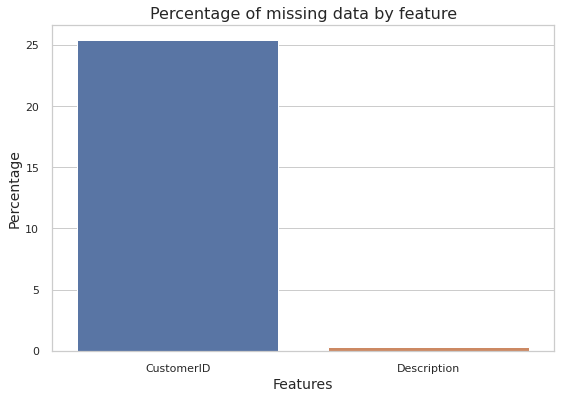

In [23]:
visualize_missing_percent(df)

**Missing 25% of CustomerID.**

*  The missing unique identified of customers could post a problem as market/customer segmentation requires grouping each unique customer into a group.

<br>

So, we have to deal with this missing values.

For the missing the customer ID's, I assume that these orders were not made by the customers already in the data set because those customers already have ID's. Since this is an online purchase, these transactions could be made under 'Guest Checkout' which doesn't require the customer to create an account.

<br>

I also don't want to assign these orders to those customers who are having IDs because this would alter the insights I draw from the data. 

<br>

Instead of dropping the null CustomerID values which amounts to ~25% of data, Let's assign those rows a unique customer ID per order using InvoiceNo. This will act as a new customer for each unique order.

Now Lets' check if InvoiceNo has unique mapping with Customer ID so that each InvoiceNo corresponding to Null CustomerID can be assigned as New Customer.

In [24]:
##Finding unique customeID per InvoiceNo and arranging it in descending order.
df.groupby(['InvoiceNo'])['CustomerID'].nunique().reset_index(name='nunique').sort_values(['nunique'], ascending=False).head(5)

,InvoiceNo,nunique
0,536365,1
16912,571199,1
16921,571214,1
16920,571213,1
16919,571212,1


This shows that each Invoice relates to maximum of 1 Customer.

In [25]:
customer = df['CustomerID'].nunique()
null_invoices = df[df.CustomerID.isnull()]['InvoiceNo'].nunique()
print("Number of Customers:", customer)
print("Number of Orders where CustomerID in Null:", null_invoices)

Number of Customers: 4372
Number of Orders where CustomerID in Null: 3709


In [26]:
#Assigning InvoiceNum as CustID, whose CustID values are Null.
df.loc[df['CustomerID'].isnull(), ['CustomerID']] = df['InvoiceNo']

#Remove all non digits from CustID (Since Invoice can contains "C" referring to cancellations)
df['CustomerID'] = df['CustomerID'].astype(str).str.replace('\D+', '')

#Convert back to integer
df['CustomerID'] = pd.to_numeric(df['CustomerID'])

new_ids = df['CustomerID'].nunique()

print("Number of Customers + Number of Orders where CustomerID in Null:", customer + null_invoices)
print("Number of New ID's:", new_ids)

Number of Customers + Number of Orders where CustomerID in Null: 8081
Number of New ID's: 8081


In [27]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,178500,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,178500,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,178500,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,178500,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,178500,United Kingdom


Missing values found..Calculating the total...
The total number of missing entries found is 1454, that is 0.27%

             Total  Percentage
Description   1454    0.273431



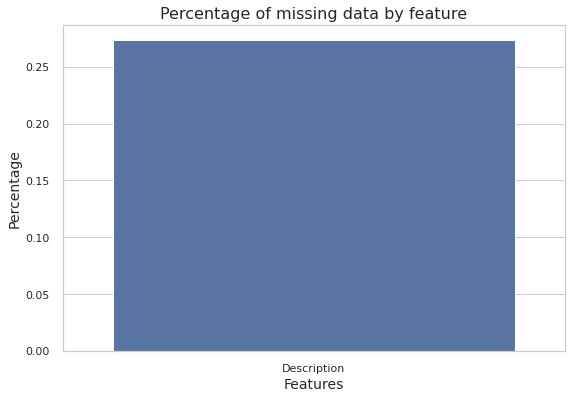

In [28]:
visualize_missing_percent(df)

Since, only 0.27% of description are missing. Let's drop them.

In [29]:
df.dropna(inplace=True)

In [30]:
visualize_missing_percent(df)

Hurray! There are no missing values in the data.


In [31]:
new_rows = df.shape[0]

In [32]:
print(round((new_rows/original_rows)*100,2),"% of data is retained after cleaning and analysis")

97.86 % of data is retained after cleaning and analysis


#**Exploratory Data Analysis**

##**Data Preprocessing**

Create a new columns **TotalAmount** by combining UnitPrice and Quantity.

In [33]:
df['TotalAmount'] = df['UnitPrice'] * df['Quantity']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,178500,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,178500,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,178500,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,178500,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,178500,United Kingdom,20.34


Convert **InvoiceDate** to datatime format. And split them into hour, min, day, month, year columns

In [34]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530308 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530308 non-null  object        
 1   StockCode    530308 non-null  object        
 2   Description  530308 non-null  object        
 3   Quantity     530308 non-null  int64         
 4   InvoiceDate  530308 non-null  datetime64[ns]
 5   UnitPrice    530308 non-null  float64       
 6   CustomerID   530308 non-null  int64         
 7   Country      530308 non-null  object        
 8   TotalAmount  530308 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 40.5+ MB


In [36]:
df['month']=df['InvoiceDate'].dt.month_name()
df['day'] = df['InvoiceDate'].dt.day_name()
df['year'] = df['InvoiceDate'].dt.year
df["hour"] = df["InvoiceDate"].apply(lambda x: x.hour)
df["minute"] = df["InvoiceDate"].apply(lambda x: x.minute)

Since we are having 1 year of data. Let's drop year column.
<br>
And we will be utilizing hour column and dropping of minute column aswell.

In [37]:
df.drop(columns=['year','minute'],axis=1,inplace=True)

In [38]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,month,day,hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,178500,United Kingdom,15.30,December,Wednesday,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,178500,United Kingdom,20.34,December,Wednesday,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,178500,United Kingdom,22.00,December,Wednesday,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,178500,United Kingdom,20.34,December,Wednesday,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,178500,United Kingdom,20.34,December,Wednesday,8


##**Analysis of Columns**

In [39]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalAmount', 'month', 'day',
       'hour'],
      dtype='object')

###**Invoice Number**

Invoice number is a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

Now let us now look at the number of canceled orders in the data.

In [40]:
# String to be searched in start of string 
search ="C"
  
# boolean series returned with False at place of NaN
bool_series = df["InvoiceNo"].str.startswith(search, na=False)
  
# displaying filtered dataframe
cancel_order = df[bool_series]

cancel_order.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,month,day,hour
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,145270,United Kingdom,-27.50,December,Wednesday,9
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,153110,United Kingdom,-4.65,December,Wednesday,9
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,175480,United Kingdom,-19.80,December,Wednesday,10
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,175480,United Kingdom,-6.96,December,Wednesday,10
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,175480,United Kingdom,-6.96,December,Wednesday,10


In [41]:
print("Shape of cancelled order", cancel_order.shape)

Shape of cancelled order (9219, 12)


In [42]:
cancel_order_percentage = cancel_order['InvoiceNo'].count()*100/df['InvoiceNo'].count()
print("We have about ",round(cancel_order_percentage,2),"% of cancelled orders.")

We have about  1.74 % of cancelled orders.


###**Country**

**Top 10 countries with most cancelled Orders**

In [43]:
cancel_order_country = cancel_order.groupby('Country')['InvoiceNo'].count().reset_index()

In [44]:
cancel_order_country_top10 = cancel_order_country.sort_values('InvoiceNo',ascending=False, ignore_index=True).head(10)
cancel_order_country_top10 = cancel_order_country_top10.rename({'InvoiceNo':'Num of order cancelled'},axis=1)
cancel_order_country_top10

,Country,Num of order cancelled
0,United Kingdom,7791
1,Germany,453
2,EIRE,300
3,France,147
4,USA,112
5,Australia,74
6,Spain,48
7,Italy,45
8,Belgium,38
9,Japan,37


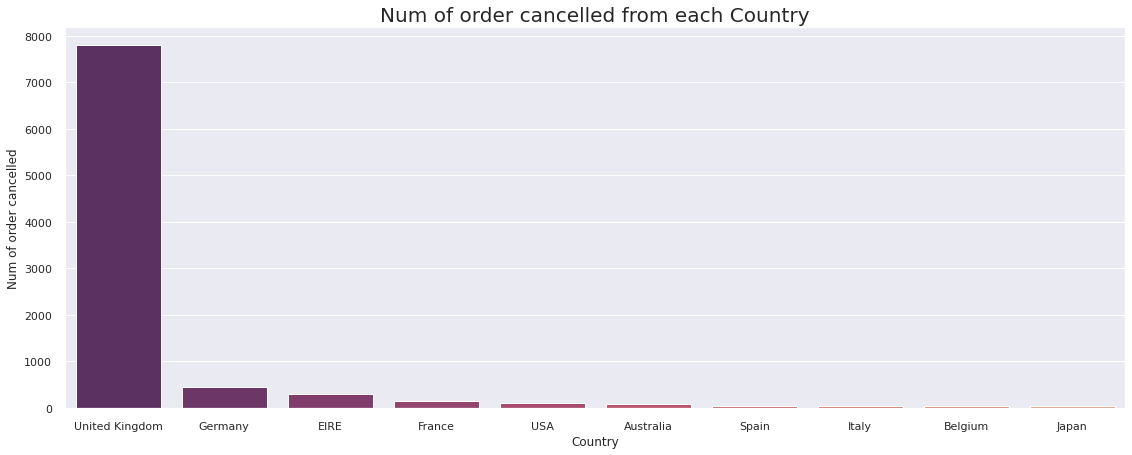

In [45]:
bargraph(cancel_order_country_top10,'Country','Num of order cancelled','Num of order cancelled from each Country')

From the above graph we can observe that cancelled orders will be more in UK and less in Japan.

Let's remove the cancelled order data from the dataset.

In [46]:
df = df[~df.InvoiceNo.str.contains("C", na=False)]

In [47]:
new_rows = df.shape[0]

**Top 10 countries with most orders**

In [48]:
## Apply groupby function on country and Invoice No.
country_count = df.groupby('Country')['InvoiceNo'].count().reset_index()

In [49]:
country_count.head()

,Country,InvoiceNo
0,Australia,1183
1,Austria,398
2,Bahrain,18
3,Belgium,2031
4,Brazil,32


In [50]:
## From country_count variable finding top 10 countries
Top_ten_country = country_count.sort_values('InvoiceNo', ascending=False, ignore_index=True).head(10)

In [51]:
## Adding country percentage column to top 10 countries data frame
Top_ten_country['Country_percent']= round(Top_ten_country['InvoiceNo']*100/df['InvoiceNo'].count(),2)
Top_ten_country = Top_ten_country.rename({'Country_percent':'Percentage of Order'},axis=1)
Top_ten_country

,Country,InvoiceNo,Percentage of Order
0,United Kingdom,476264,91.40
1,Germany,9012,1.73
2,France,8378,1.61
3,EIRE,7872,1.51
4,Spain,2475,0.47
5,Netherlands,2363,0.45
6,Belgium,2031,0.39
7,Switzerland,1951,0.37
8,Portugal,1484,0.28
9,Australia,1183,0.23


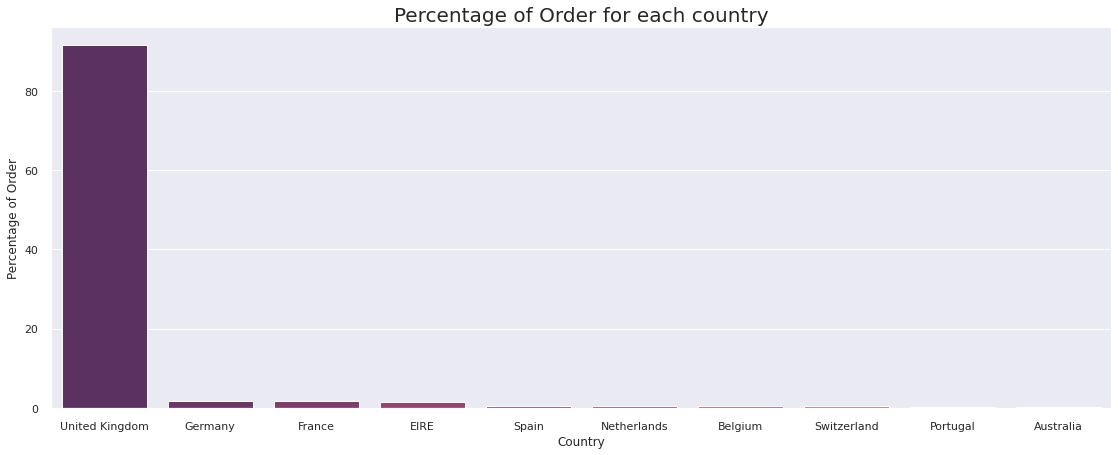

In [52]:
bargraph(Top_ten_country,'Country','Percentage of Order','Percentage of Order for each country')

About 91% of orders are coming from UK, so we can say that most customers and most orders will be from United Kingdom.

**Bottom 10 countries with orders**

In [53]:
## Apply groupby function on country and Invoice No.
country_count = df.groupby('Country')['InvoiceNo'].count().reset_index()

In [54]:
## From country_count variable finding top 10 countries
Bottom_ten_country = country_count.sort_values('InvoiceNo', ascending=True, ignore_index=True).head(10)
Bottom_ten_country = Bottom_ten_country.rename({'InvoiceNo':'Num of orders'},axis=1)
Bottom_ten_country

,Country,Num of orders
0,Saudi Arabia,9
1,Bahrain,18
2,Czech Republic,25
3,Brazil,32
4,Lithuania,35
5,Lebanon,45
6,RSA,58
7,European Community,60
8,United Arab Emirates,68
9,Malta,112


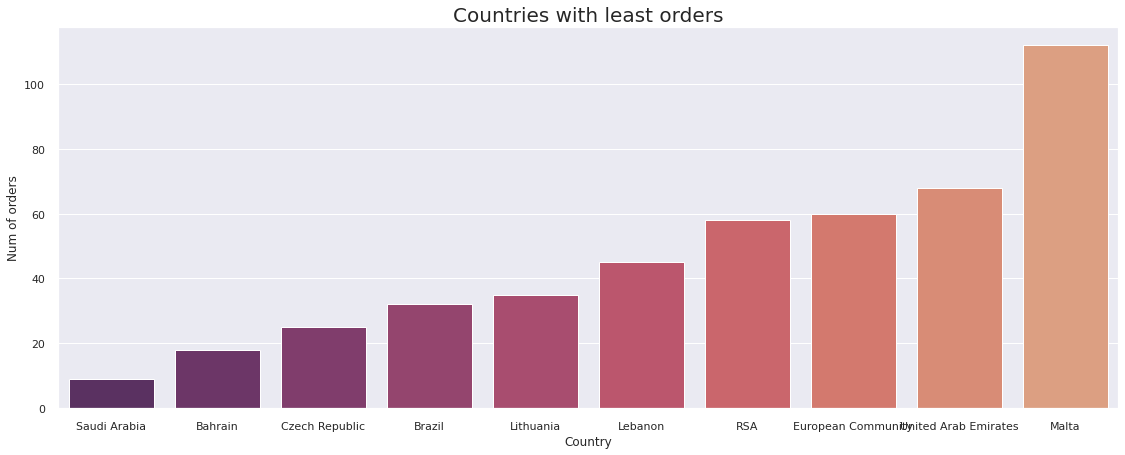

In [55]:
bargraph(Bottom_ten_country,'Country','Num of orders','Countries with least orders')

We have least number of orders and customers from Saudi Arabia.

###**CustomerID and TotalAmount**

CustomerId is a unique ID which is used to represent Customer.
<br>
Now, lets analyse which customer spends most amount on shopping.

In [56]:
PercentSales = df.groupby(["CustomerID"]).TotalAmount.sum().sort_values(ascending = False).iloc[:20].reset_index()
PercentSales.head(10)

,CustomerID,TotalAmount
0,146460,280206.02
1,181020,259657.30
2,174500,194230.79
3,164460,168472.50
4,149110,143597.28
5,124150,124914.53
6,141560,117040.53
7,175110,91062.38
8,160290,80676.84
9,123460,77183.60


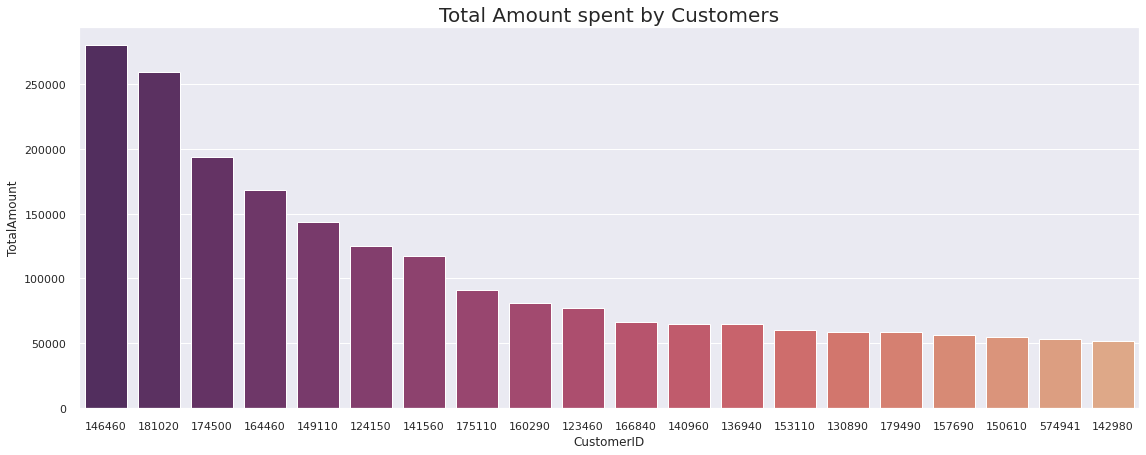

In [57]:
bargraph(PercentSales,'CustomerID','TotalAmount','Total Amount spent by Customers')

We can say that the customer with cutomerID - 146460, spends more money on shopping.

###**CustomerID and InvoiceNumber**

In [58]:
Most_shopped = df.groupby(["CustomerID"]).InvoiceNo.count().sort_values(ascending = False).iloc[:20].reset_index()
Most_shopped.head(10)

,CustomerID,InvoiceNo
0,178410,7523
1,149110,5667
2,140960,5111
3,127480,4243
4,146060,2654
5,153110,2353
6,146460,2080
7,130890,1810
8,132630,1657
9,142980,1637


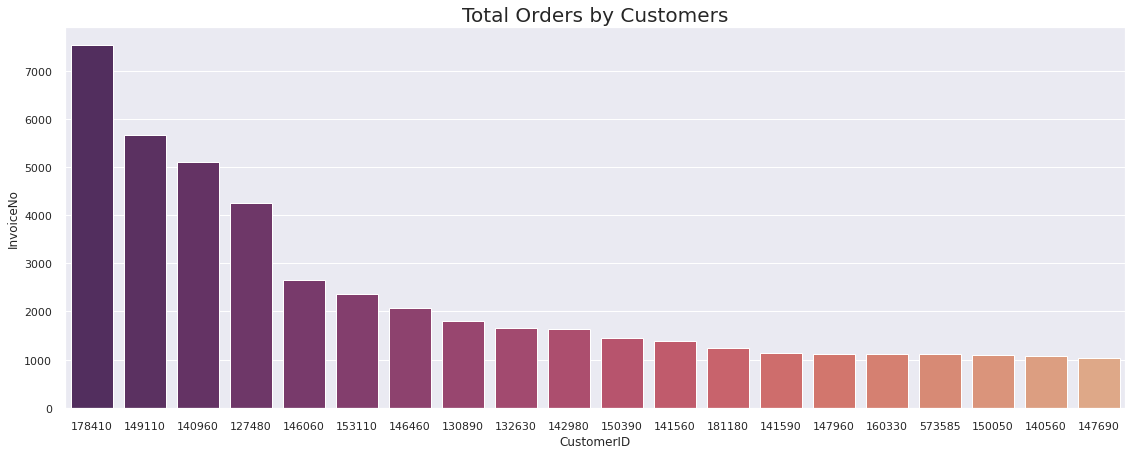

In [59]:
bargraph(Most_shopped,'CustomerID','InvoiceNo','Total Orders by Customers')

We can say that the customer with cutomerID - 178410 is a shopaholic, who shops/orders more.

###**Day**

In [60]:
day_df=df['day'].value_counts().reset_index()
day_df.rename(columns={'index': 'Day_Name'}, inplace=True)
day_df.rename(columns={'day': 'Count'}, inplace=True)
day_df

,Day_Name,Count
0,Thursday,99653
1,Tuesday,98346
2,Monday,92006
3,Wednesday,90879
4,Friday,79280
5,Sunday,60925


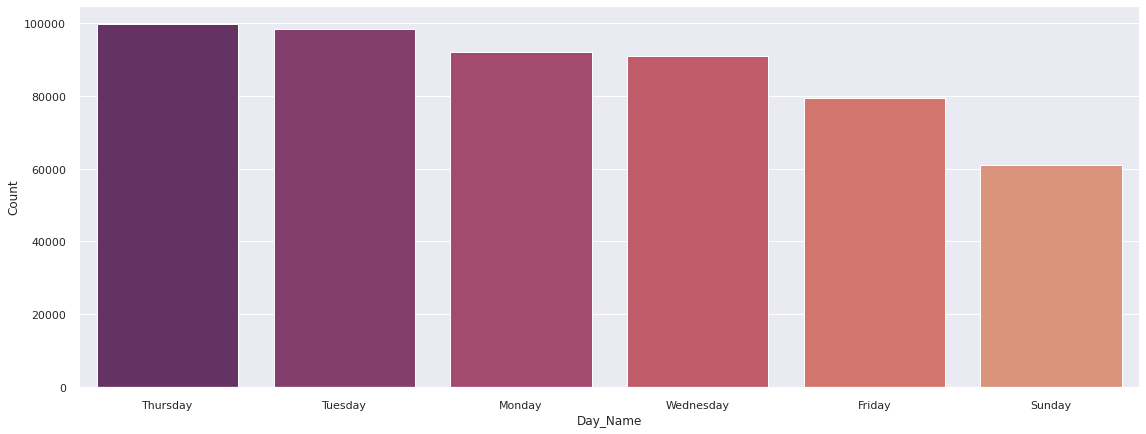

In [61]:
bargraph(day_df,'Day_Name','Count','')

We can observe that shopping is more on weekdays compared to weekend.

###**Month**

In [62]:
month_df=df['month'].value_counts().reset_index()
month_df.rename(columns={'index': 'Month_Name'}, inplace=True)
month_df.rename(columns={'month': 'Count'}, inplace=True)
month_df

,Month_Name,Count
0,November,80925
1,December,65305
2,October,57968
3,September,48623
4,July,38185
5,May,35787
6,June,35589
7,March,35297
8,August,34103
9,January,33859


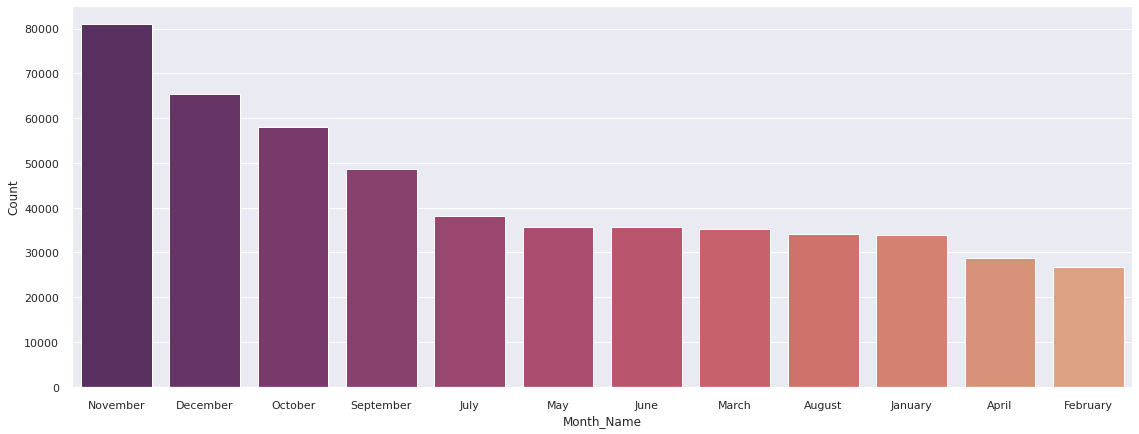

In [63]:
bargraph(month_df,'Month_Name','Count','')

Shoppings will be more on year ends i.e, Sep, Oct, Nov and Dec.
<br>
We can even say that since festivals will be more during this period shopping will be more.

###**Hour**

In [64]:
hour_df=df['hour'].value_counts().reset_index()
hour_df.rename(columns={'index': 'Hour_Name'}, inplace=True)
hour_df.rename(columns={'hour': 'Count'}, inplace=True)
hour_df

,Hour_Name,Count
0,15,75254
1,12,75012
2,13,69121
3,14,64541
4,11,54949
5,16,52724
6,10,47461
7,9,33699
8,17,27360
9,8,8798


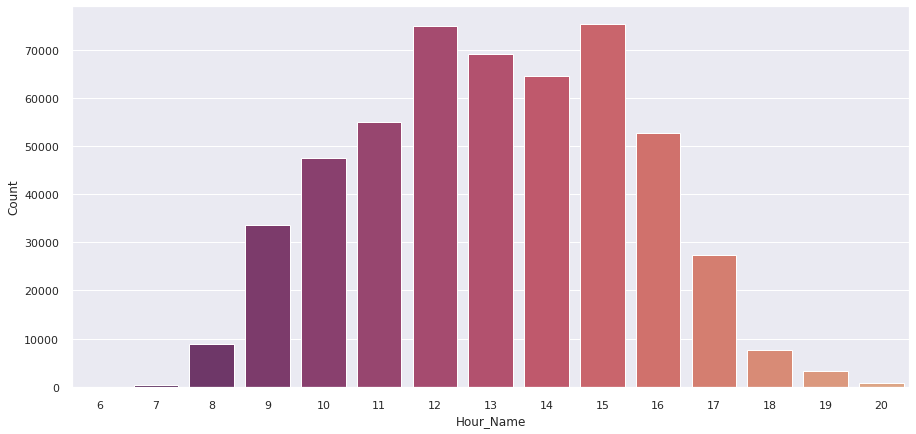

In [65]:
plt.figure(figsize=(15,7))
sns.barplot(x='Hour_Name',y='Count',data=hour_df,palette='flare_r')
plt.show()

In [66]:
##Splitting into 3 groups such as morning, afternoon and evening based on timings.
df['Time_type']=df['hour'].apply(time_type)

<function matplotlib.pyplot.show(*args, **kw)>

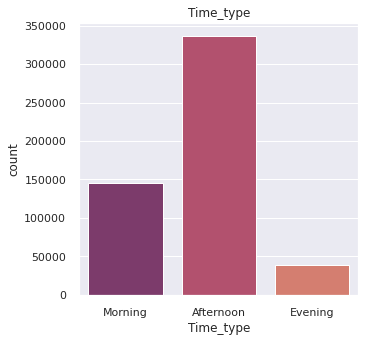

In [67]:
plt.figure(figsize=(5,5))
plt.title('Time_type')
sns.countplot(x='Time_type',data=df,palette='flare_r')
plt.show

We can observe that most of the purchase happens during afternoon.

###**Description**

In [68]:
Description_df=df['Description'].value_counts().reset_index()
Description_df.rename(columns={'index': 'Description_Name'}, inplace=True)
Description_df.rename(columns={'Description': 'Count'}, inplace=True)
Description_df.head()

,Description_Name,Count
0,WHITE HANGING HEART T-LIGHT HOLDER,2304
1,JUMBO BAG RED RETROSPOT,2109
2,REGENCY CAKESTAND 3 TIER,1999
3,PARTY BUNTING,1693
4,LUNCH BAG RED RETROSPOT,1568


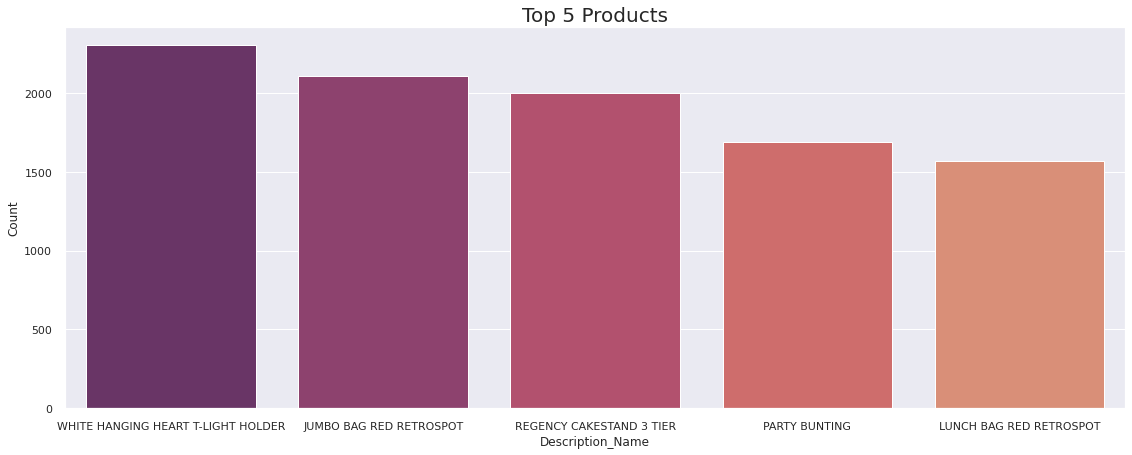

In [69]:
bargraph(Description_df[:5],"Description_Name","Count","Top 5 Products")

The top 5 selling products are as follows -

1.   White Hanging Heart T-Light Holder
2.   Jumbo Bag Red Retrospot

1.   Regency Cakestand 3 tier
2.   Party Bunting

1.   Lunch Bag Red Retrospot


#**Model Building**

##**RFM model:**

RFM is a data modeling method which allows marketers to target specific clusters of customers with communications that are much more relevant for their particular behavior – and thus generate much higher rates of response, plus increased loyalty and customer lifetime value. Like other segmentation methods, an RFM model is a powerful way to identify groups of customers for special treatment. RFM stands for recency, frequency and monetary, which are just three metrics that describe what your customers did.

**Receny:** How recent was each customer's last purchase

**Frequency:** How many times the customer purchased in the last 12 months

**Monetary Value:** How much has the customer spent in the last 12 months

The first step in building an RFM model is to assign Recency, Frequency and Monetary values to each customer.

The second step is to divide the customer list into tiered groups for each of the three dimensions (R, F and M)

In [70]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,month,day,hour,Time_type
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,178500,United Kingdom,15.30,December,Wednesday,8,Morning
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,178500,United Kingdom,20.34,December,Wednesday,8,Morning
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,178500,United Kingdom,22.00,December,Wednesday,8,Morning
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,178500,United Kingdom,20.34,December,Wednesday,8,Morning
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,178500,United Kingdom,20.34,December,Wednesday,8,Morning


To create a Recency feature variable, we need to decide the reference date for analysis and we wil define the reference date as one day after the last transaction.

We fix a reference date for finding the recent transactions. The reference date would be a day after the most recent transaction date in the dataset. Then we calculate the days difference between the most recent transaction carried out by the customer and this reference date

In [71]:
Latest_Date = df.InvoiceDate.max()

#timedelta function returns to total number of seconds
Latest_Date = Latest_Date + dt.timedelta(days=1)

Latest_Date

Timestamp('2011-12-10 12:50:00')

Recency = Latest Date - Last Invoice Data
<br>
Frequency = count of invoice no. of transaction(s)
<br>
Monetary = Sum of Total Amount spent by each customer

In [72]:
#Create RFM Modelling scores for each customer
rfm_df = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (Latest_Date - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalAmount': lambda x: x.sum()})

#Convert Invoice Date into type int
rfm_df['InvoiceDate'] = rfm_df['InvoiceDate'].astype(int)


#Rename column names to Recency, Frequency and Monetary
rfm_df.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'TotalAmount': 'Monetary'}, inplace=True)

rfm_df.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,123460,326,1,77183.60
1,123470,2,182,4310.00
2,123480,75,31,1797.24
3,123490,19,73,1757.55
4,123500,310,17,334.40


**Checking for Skewness**

Recency's: Skew: 0.821991244760207, : SkewtestResult(statistic=23.687971347424387, pvalue=4.797165585060265e-124)
Frequency's: Skew: 18.111777171070052, : SkewtestResult(statistic=101.48909956550811, pvalue=0.0)
Monetary's: Skew: 22.487005283902228, : SkewtestResult(statistic=107.27660070802828, pvalue=0.0)


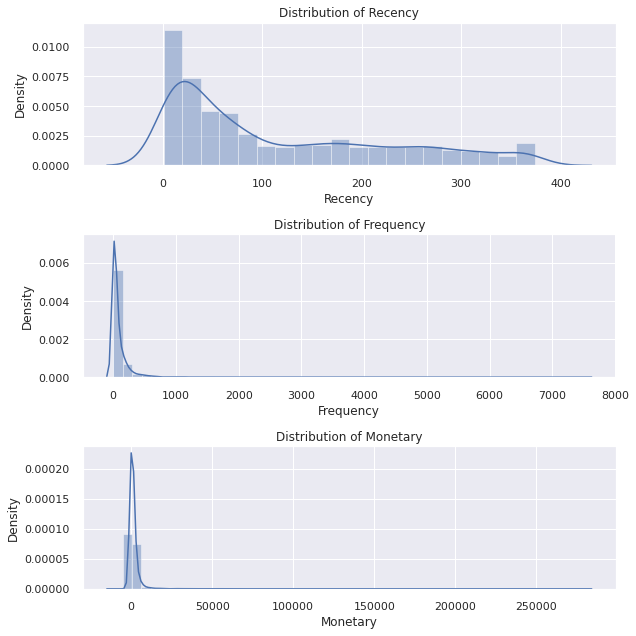

In [73]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(rfm_df,'Recency')

plt.subplot(3, 1, 2)
check_skew(rfm_df,'Frequency')

plt.subplot(3, 1, 3)
check_skew(rfm_df,'Monetary')

plt.tight_layout()

**Removing Skewness**

In [74]:
#Apply handle_neg_n_zero function to Recency and Monetary columns 
rfm_df['Recency'] = [handle_neg_n_zero(x) for x in rfm_df.Recency]
rfm_df['Monetary'] = [handle_neg_n_zero(x) for x in rfm_df.Monetary]

#Perform Log transformation to bring data into normal or near normal distribution
Log_Tfd_Data = rfm_df[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

Recency's: Skew: -0.7567567008612929, : SkewtestResult(statistic=-22.151601232914715, pvalue=1.0067654460411076e-108)
Frequency's: Skew: -0.39018793781571093, : SkewtestResult(statistic=-12.32972055171954, pvalue=6.266366199553273e-35)
Monetary's: Skew: -1.0510117190049955, : SkewtestResult(statistic=-28.623513962907282, pvalue=3.4256944270276624e-180)


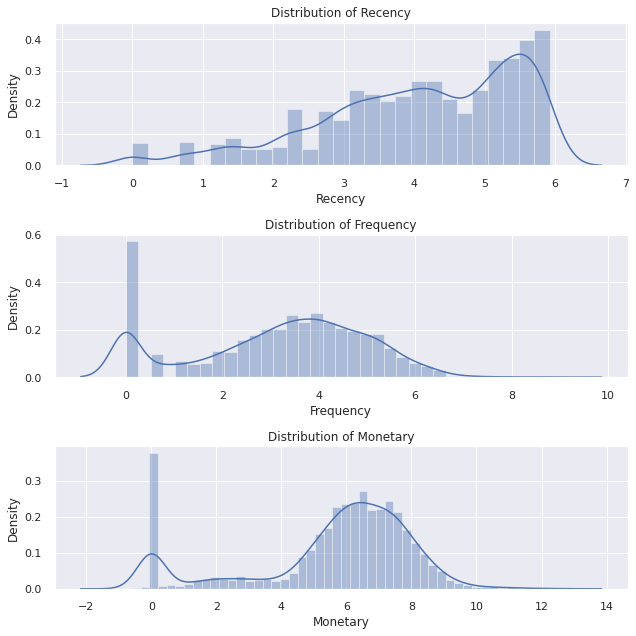

In [75]:
# Check for skewness after log transformation
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(Log_Tfd_Data,'Recency')

plt.subplot(3, 1, 2)
check_skew(Log_Tfd_Data,'Frequency')

plt.subplot(3, 1, 3)
check_skew(Log_Tfd_Data,'Monetary')

plt.tight_layout()

As of now we have completed the first step i.e., building a RFM model.
<br>
Now its time to divide the customers into tiered groups.

In [76]:
#Split into four segments using quantiles
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,24.0,8.0,145.560
0.50,71.0,32.0,518.015
0.75,198.0,90.0,1474.225


In [77]:
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.25: 24.0, 0.5: 71.0, 0.75: 198.0},
 'Frequency': {0.25: 8.0, 0.5: 32.0, 0.75: 90.0},
 'Monetary': {0.25: 145.56, 0.5: 518.0150000000001, 0.75: 1474.2250000000001}}

Now, lets divide the customer into tiered groups.
<br>

Customer with RFM score 111 - Best or Targer Customer.
<br>
Customer with RFM score 444 - Worst Customer.

In [78]:
#Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values
rfm_df['R'] = rfm_df['Recency'].apply(RScoring, args=('Recency',quantiles,))
rfm_df['F'] = rfm_df['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
rfm_df['M'] = rfm_df['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
rfm_df.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
123460,326,1,77183.60,4,4,1
123470,2,182,4310.00,1,1,1
123480,75,31,1797.24,3,3,1
123490,19,73,1757.55,1,2,1
123500,310,17,334.40,4,3,3


Lets assign some names to segments of interest.
<br>
<br>
**Best Customers**– This group consists of those customers who are found in R-Tier-1, F-Tier-1 and M-Tier-1 i.e.,1-1-1, meaning that they transacted recently, do so often and spend more than other customers.
<br>

**High-spending New Customers**– This group consists of those customers in 1-4-1 and 1-4-2. These are customers who transacted only once, but very recently and they spent a lot.
<br>

**Lowest-Spending Active Loyal Customers** – This group consists of those customers in segments 1-1-3 and 1-1-4 (they transacted recently and do so often, but spend the least).
<br>


Marketers should assemble groups of customers most relevant for their particular business objectives and retention goals.

By focusing on the behavioral patterns of particular groups, RFM marketing allows marketers to communicate with customers in a much more effective manner.
<br>
<br>
**Best Customers –** Communications with this group should make them feel valued and appreciated. These customers likely generate a disproportionately high percentage of overall revenues and thus focusing on keeping them happy should be a top priority. Further analyzing their individual preferences and affinities will provide additional opportunities for even more personalized messaging.
<br>

**High-spending New Customers** – It is always a good idea to carefully “incubate” all new customers, but because these new customers spent a lot on their first purchase, it’s even more important. Like with the Best Customers group, it’s important to make them feel valued and appreciated – and to give them terrific incentives to continue interacting with the brand.
<br>

**Lowest-Spending Active Loyal Customers** – These repeat customers are active and loyal, but they are low spenders. Marketers should create campaigns for this group that make them feel valued, and incentivize them to increase their spend levels. As loyal customers, it often also pays to reward them with special offers if they spread the word about the brand to their friends, e.g., via social networks.

In [79]:
#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
rfm_df['RFMGroup'] = rfm_df.R.map(str) + rfm_df.F.map(str) + rfm_df.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
rfm_df['RFMScore'] = rfm_df[['R', 'F', 'M']].sum(axis = 1)
rfm_df.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
CustomerID,,,,,,,,
123460,326,1,77183.60,4,4,1,441,9
123470,2,182,4310.00,1,1,1,111,3
123480,75,31,1797.24,3,3,1,331,7
123490,19,73,1757.55,1,2,1,121,4
123500,310,17,334.40,4,3,3,433,10


In [80]:
rfm_df.RFMScore.describe()

count    6412.000000
mean        7.504523
std         2.715803
min         3.000000
25%         5.000000
50%         8.000000
75%        10.000000
max        12.000000
Name: RFMScore, dtype: float64

The Customers with lower RFM score (starting from 3) are the potential/Target customers. And the customers with higher RFM score are worst or not so usefull customer.
<br>
Based on business requirement we can put a threshold and select Target customers.

Now lets apply log function to remove skewness.

In [81]:
rfm_df_scaled = pd.DataFrame()

In [82]:
rfm_df_scaled["Recency"] = np.log(rfm_df.Recency)
rfm_df_scaled["Frequency"] = np.log(rfm_df.Frequency)
rfm_df_scaled["Monetary"] = np.log(rfm_df.Monetary)

In [83]:
rfm_df_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
123460,5.786897,0.000000,11.253942
123470,0.693147,5.204007,8.368693
123480,4.317488,3.433987,7.494007
123490,2.944439,4.290459,7.471676
123500,5.736572,2.833213,5.812338


##**Kmeans Clustering**

It is an iterative algorithm that divides the unlabeled dataset into k different clusters in such a way that each dataset belongs only one group that has similar properties.

In [84]:
Kmeans_model = rfm_df_scaled.copy()

In [85]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(Kmeans_model)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(Kmeans_model, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5679927751568372
For n_clusters=3, the silhouette score is 0.40156541108922816
For n_clusters=4, the silhouette score is 0.34855871992597215
For n_clusters=5, the silhouette score is 0.3579010725670599
For n_clusters=6, the silhouette score is 0.34290641357858337
For n_clusters=7, the silhouette score is 0.3131674585019234
For n_clusters=8, the silhouette score is 0.3134802227973649


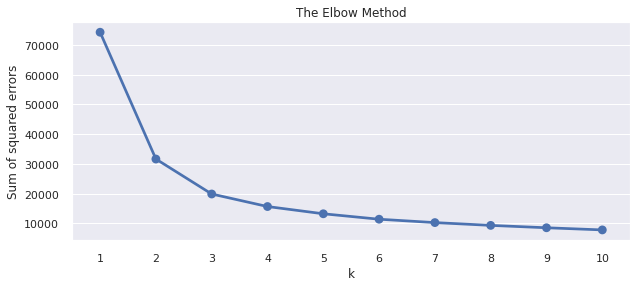

In [86]:
### Features Used in training K Means - Log Transformed Recency, Frequency and Monetary values
data_norm = Kmeans_model[["Recency", "Frequency", "Monetary"]]

sse = {}
# Fit KMeans and calculate SSE for each k
for k in range(1, 11):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(data_norm)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_
    
# Plotting the elbow plot
plt.figure(figsize=(10,4))
plt.title('The Elbow Method')
plt.xlabel('k'); 
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

Based on Silhouette score and Elbow method, we can consider the optimal number of clusters as 3.
<br> 
Now I am bulding K-means model using k=3.

In [87]:
n_clusters = 3
kmeans = KMeans(n_clusters = n_clusters, random_state=1)
kmeans.fit(data_norm)
Kmeans_model["cluster"] = kmeans.predict(data_norm)

In [88]:
Kmeans_model.head()

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
123460,5.786897,0.000000,11.253942,0
123470,0.693147,5.204007,8.368693,2
123480,4.317488,3.433987,7.494007,2
123490,2.944439,4.290459,7.471676,2
123500,5.736572,2.833213,5.812338,0


Checking Mean RFM values in different clusters to understand cluster properties

In [89]:
Kmeans_model.groupby(["cluster"])[['Recency','Frequency', 'Monetary']].mean()

,Recency,Frequency,Monetary
cluster,,,
0,4.707349,2.883383,5.764912
1,4.441999,0.243248,0.864840
2,3.169007,4.807029,7.596160


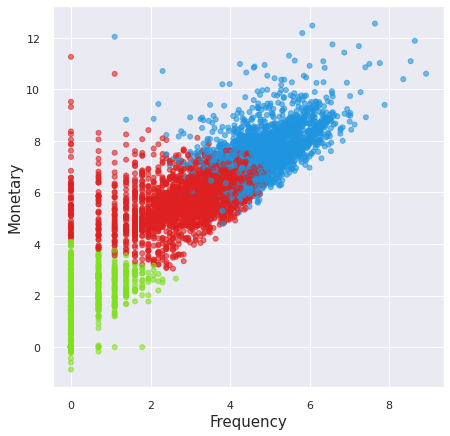

In [90]:
# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

## add to dataframe
Kmeans_model['cen_x'] = Kmeans_model.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
Kmeans_model['cen_y'] = Kmeans_model.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})

# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF']
Kmeans_model['c'] = Kmeans_model.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})

# Plot clusters
plt.figure(figsize=(7,7))
plt.scatter(Kmeans_model.Frequency, Kmeans_model.Monetary, c=Kmeans_model.c, alpha = 0.6, s=25)
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Monetary', fontsize=15)
plt.show()

Text(0, 0.5, 'Monetary')

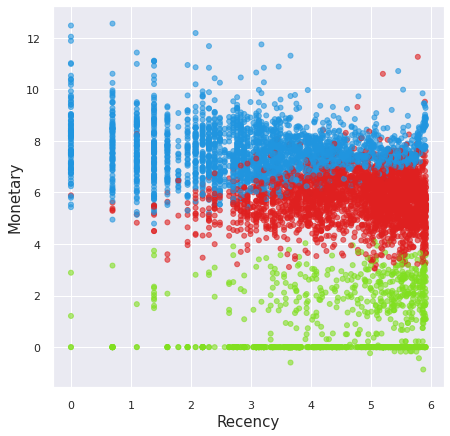

In [91]:
# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

## add to dataframe
Kmeans_model['cen_x'] = Kmeans_model.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
Kmeans_model['cen_y'] = Kmeans_model.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})

# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF']
Kmeans_model['c'] = Kmeans_model.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})

# Plot clusters
plt.figure(figsize=(7,7))
plt.scatter(Kmeans_model.Recency, Kmeans_model.Monetary, c=Kmeans_model.c, alpha = 0.6, s=25)
plt.xlabel('Recency', fontsize=15)
plt.ylabel('Monetary', fontsize=15)

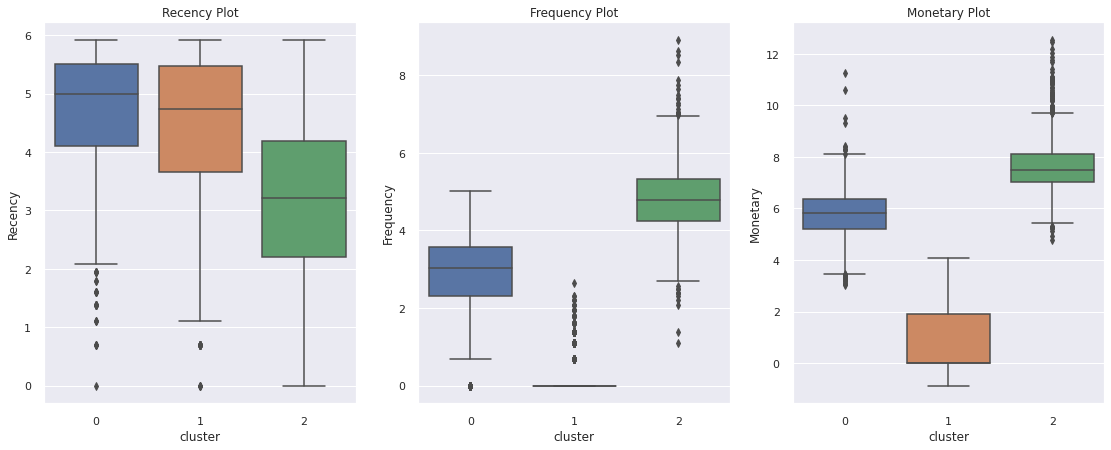

In [92]:
# plot
plt.figure(figsize=(19,7))
plt.subplot(1, 3, 1)
plt.title("Recency Plot")
sns.boxplot(x='cluster', y='Recency', data=Kmeans_model)
plt.subplot(1, 3, 2)
plt.title("Frequency Plot")
sns.boxplot(x='cluster', y='Frequency', data=Kmeans_model)
plt.subplot(1,3,3)
plt.title("Monetary Plot")
sns.boxplot(x='cluster', y='Monetary', data=Kmeans_model)
plt.show()

##**Hierarchical Clustering**

In [93]:
Hierarchical_model = rfm_df_scaled.copy()

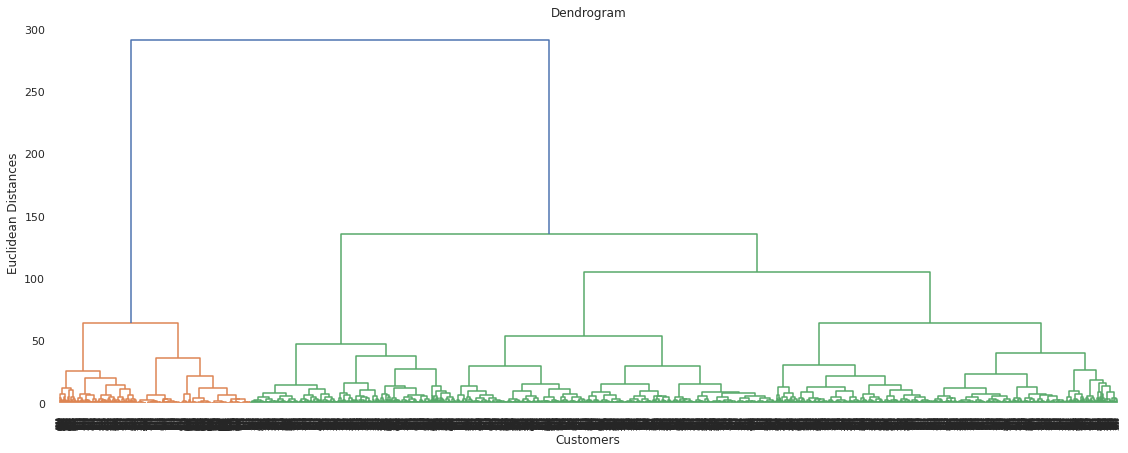

In [94]:
# Using the dendogram to find the optimal number of clusters
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(Hierarchical_model, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.show() # find largest vertical distance we can make without crossing any other horizontal line

In [104]:
# Fitting hierarchical clustering to the mall dataset
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
Hierarchical_model["cluster"] = hc.fit_predict(Hierarchical_model)

In [105]:
Hierarchical_model.head()

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
123460,5.786897,0.000000,11.253942,0
123470,0.693147,5.204007,8.368693,2
123480,4.317488,3.433987,7.494007,0
123490,2.944439,4.290459,7.471676,2
123500,5.736572,2.833213,5.812338,0
